In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import tensorflow as tf
import keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import read_data as rd  # Importing the read_data.py module

2024-06-05 11:41:35.331186: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-05 11:41:35.980817: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Allow TensorFlow to allocate GPU memory dynamically
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

# With allow_growth=True, TensorFlow will allocate GPU memory as needed and won't allocate all memory upfront.

2024-06-05 11:41:36.723323: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-05 11:41:36.818687: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-05 11:41:36.818868: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
# Load data
dataset_dir = '/home/ecappiell/datasets/full'
data_arrays, labels, class_ids = rd.process_mafaulda_data(dataset_dir)

In [4]:
# Original sampling rate (in Hz)
original_sampling_rate = 50 * 10**3  # 50 kHz

# Target sampling rate (in Hz)
target_sampling_rate = 0.1 * 10**3  # 0.1 kHz

# Downsample the data
downsampled_data = rd.downsample_data(data_arrays, original_sampling_rate, target_sampling_rate)

In [5]:
# Function to normalize the data using min-max scaling
def normalize_data(data):
    min_val = np.min(data, axis=0)
    max_val = np.max(data, axis=0)
    normalized = (data - min_val) / (max_val - min_val)
    return normalized

In [6]:
# Normalize the downsampled data
normalized_data = np.array([normalize_data(signal) for signal in downsampled_data])

In [40]:
# Define a simple neural network for classification with 1-D CNN layers
def create_model(input_shape, num_classes):
    model = Sequential([
        Conv1D(32, kernel_size=8, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Conv1D(64, kernel_size=8, activation='relu'),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    optimizer = tf.keras.optimizers.Adam()
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [41]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(normalized_data, class_ids, test_size=0.2, random_state=37)

In [42]:
# Create and train the model
input_shape = X_train.shape[1:]
num_classes = len(np.unique(class_ids))

model = create_model(input_shape, num_classes)

In [43]:
history = model.fit(X_train, y_train, epochs=30, batch_size=4, validation_split=0.2)

Epoch 1/30


312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.2790 - loss: 1.7853 - val_accuracy: 0.2885 - val_loss: 1.6463
Epoch 2/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2780 - loss: 1.6402 - val_accuracy: 0.2885 - val_loss: 1.6470
Epoch 3/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2772 - loss: 1.6377 - val_accuracy: 0.2821 - val_loss: 1.5788
Epoch 4/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2715 - loss: 1.6205 - val_accuracy: 0.2724 - val_loss: 1.5666
Epoch 5/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2863 - loss: 1.5753 - val_accuracy: 0.3494 - val_loss: 1.5310
Epoch 6/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3361 - loss: 1.5041 - val_accuracy: 0.3814 - val_loss: 1.3882
Epoch 7/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3599 - loss: 1.3825 - val_accuracy: 0.3878 - val_loss: 1.3211
Epoch 8/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3920 - loss: 1.3145 - val_accuracy: 0.3942 - val_

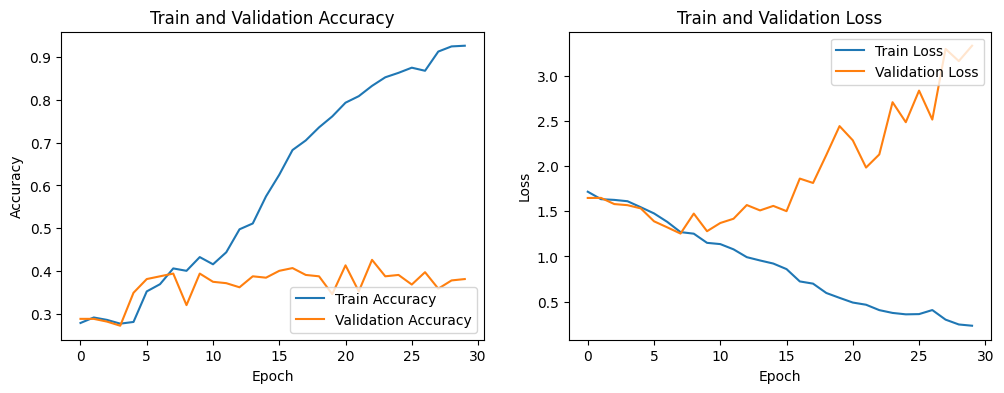

In [44]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Train and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Train and Validation Loss')

plt.show()

In [45]:
# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred_classes)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
Accuracy: 0.3760
Precision: 0.3992
Recall: 0.3760
F1 Score: 0.3647


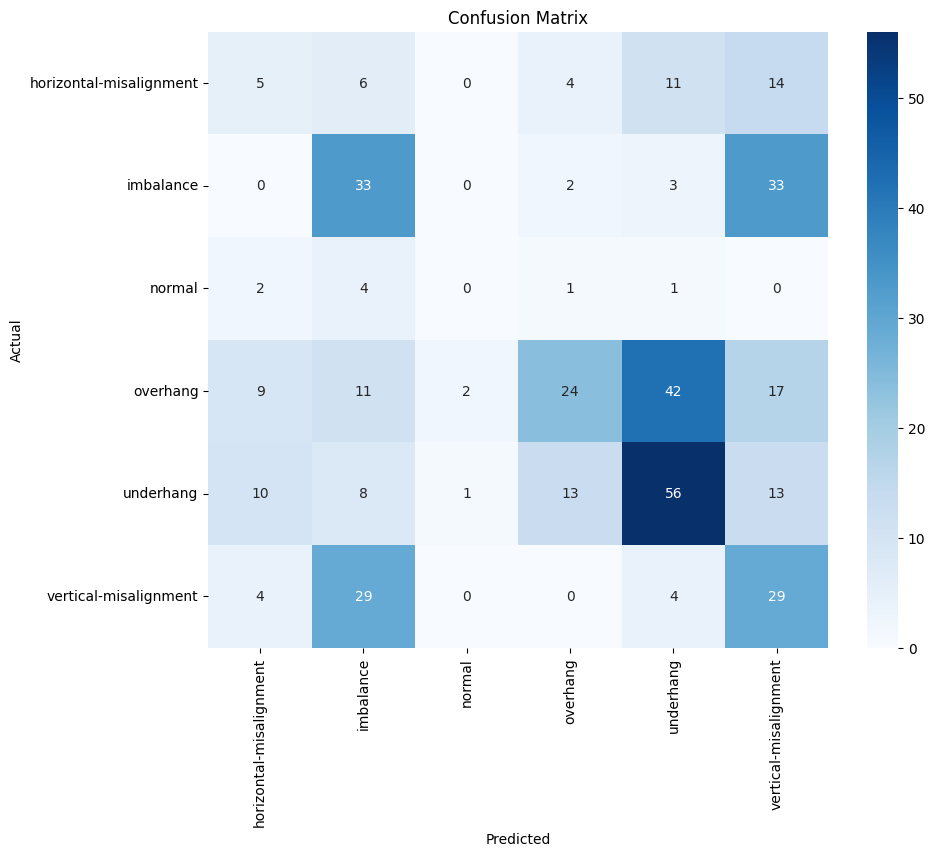

In [46]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(labels), yticklabels=np.unique(labels))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()